In [77]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# reading excel file for outages 
circuit_outage= pd.read_excel("Data/circuit_outages_ibec.xlsx", sheet_name = "Circuit Outage", usecols= "A:G") # circuit outage sheet 
circuit = pd.read_excel("Data/circuit_outages_ibec.xlsx", sheet_name = "LookUp", usecols= "A:J") # lookup sheet - circuits
outage_cause = pd.read_excel("Data/circuit_outages_ibec.xlsx", sheet_name = "LookUp", usecols= "L:M", nrows=8) # lookup sheet - outage causes

In [3]:
# renaming outage dataframe
circuit_outage = circuit_outage.rename(columns = {'Circuit Number':'circuit_number', 
                                                  'Circuit Name':'circuit_name', 
                                                  'Outage Date':'outage_date', 
                                                  'Outage CauseCode':'outage_cause_code',
                                                  'Outage Cause':'outage_cause', 
                                                  'Outage Duration (min)':'outage_duration', 
                                                  'Customers Affected':'customers_affected'})

In [4]:
# renaming circuit dataframe
circuit = circuit.rename(columns={'Circuit Number':'circuit_number', 
                                  'Circuit Name':'circuit_name', 
                                  'KV':'voltage', 
                                  'Region':'region', 
                                  'Customer Count':'customer_count',
                                  'Circuit Miles':'circuit_miles',
                                  '% Overhead':'percent_overhead',
                                  '% Underground':'percent_underground',
                                  '2023 SAIDI':'saidi_2023',
                                  '2023 SAIFI':'saifi_2023'}) # column labels for circuit table

In [5]:
# adding features 

def get_season(date):
    month = date.month
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    elif month in [9,10,11]:
        return 'Fall'
circuit_outage['season'] = circuit_outage['outage_date'].apply(get_season) # return season outage occured in
circuit_outage['cmi'] = circuit_outage['customers_affected'] * circuit_outage['outage_duration'] # return total customer minutes interrupted of

# circuit table features 
total_outage_time_2024 = circuit_outage.groupby('circuit_name')['outage_duration'].sum().reset_index(name='total_outage_time_2024')
circuit = circuit.merge(total_outage_time_2024, on ='circuit_name', how = 'left')
circuit['saidi_2024'] = ( circuit['total_outage_time_2024']/circuit['customer_count'] ).round(2)

total_outages_2024 =  circuit_outage.groupby('circuit_name').size().reset_index(name = 'total_outages_2024')
circuit = circuit.merge(total_outages_2024, on ='circuit_name', how = 'left')
circuit['saifi_2024'] = ( circuit['total_outages_2024'] / circuit['customer_count'] ).round(3)

circuit['saidi_diff_from_prev_year'] = circuit['saidi_2024'] - circuit['saidi_2023']
circuit['saifi_diff_from_prev_year'] = circuit['saifi_2024'] - circuit['saifi_2023']

df = (circuit_outage.merge(circuit, on=['circuit_number','circuit_name'], how='inner')
)



In [6]:
circuit.columns
new_column_order = ['circuit_number', 'circuit_name', 'voltage', 'region', 'customer_count',
       'circuit_miles', 'percent_overhead', 'percent_underground',
       'saidi_2023','saidi_2024', 'saidi_diff_from_prev_year',
        'saifi_2023','saifi_2024','saifi_diff_from_prev_year','total_outage_time_2024',  'total_outages_2024']
circuit = circuit[new_column_order]
circuit.head(20)

,circuit_number,circuit_name,voltage,region,customer_count,circuit_miles,percent_overhead,percent_underground,saidi_2023,saidi_2024,saidi_diff_from_prev_year,saifi_2023,saifi_2024,saifi_diff_from_prev_year,total_outage_time_2024,total_outages_2024
0,1,Orange,4,Coastal,1299,45,90,10,1.68,1.94,0.26,0.002,0.002,0.000,2521,3
1,2,Alabama,12,North,3447,29,82,18,0.57,0.60,0.03,0.001,0.001,0.000,2073,4
2,3,Green,12,Coastal,2701,26,55,45,2.40,2.04,-0.36,0.002,0.002,0.000,5514,6
3,4,Oregon,16,Desert,1147,101,85,15,1.39,1.64,0.25,0.002,0.003,0.001,1883,4
4,5,Yellow,4,North,1706,43,85,15,2.20,2.87,0.67,0.005,0.004,-0.001,4901,7
5,6,Washington,12,North,1312,38,18,82,1.79,2.24,0.45,0.002,0.002,0.000,2937,3
6,7,Lincoln,16,Mountain,1634,95,65,35,2.40,2.55,0.15,0.004,0.004,0.000,4172,6
7,8,Johnson,16,Mountain,1641,64,60,40,0.91,1.21,0.30,0.001,0.002,0.001,1981,3
8,9,Magenta,16,Mountain,2367,129,75,25,3.77,3.21,-0.56,0.006,0.004,-0.002,7597,10
9,10,Adams,4,Desert,1647,32,77,23,1.08,0.93,-0.15,0.001,0.001,0.000,1537,2


In [7]:
df.columns

Index(['circuit_number', 'circuit_name', 'outage_date', 'outage_cause_code',
       'outage_cause', 'outage_duration', 'customers_affected', 'season',
       'cmi', 'voltage', 'region', 'customer_count', 'circuit_miles',
       'percent_overhead', 'percent_underground', 'saidi_2023', 'saifi_2023',
       'total_outage_time_2024', 'saidi_2024', 'total_outages_2024',
       'saifi_2024', 'saidi_diff_from_prev_year', 'saifi_diff_from_prev_year'],
      dtype='object')

In [8]:
new_column_order = ['circuit_number', 'circuit_name', 'outage_date', 'season', 'outage_cause_code',
       'outage_cause', 'outage_duration', 'customers_affected',
       'cmi', 'voltage', 'region', 'customer_count', 'circuit_miles',
       'percent_overhead', 'percent_underground', 'saidi_2023','saidi_2024', 'saidi_diff_from_prev_year',
        'saifi_2023','saifi_2024','saifi_diff_from_prev_year','total_outage_time_2024',  'total_outages_2024'
         ]
df = df[new_column_order]

In [9]:
df.head(20)

,circuit_number,circuit_name,outage_date,season,outage_cause_code,outage_cause,outage_duration,customers_affected,cmi,voltage,...,percent_overhead,percent_underground,saidi_2023,saidi_2024,saidi_diff_from_prev_year,saifi_2023,saifi_2024,saifi_diff_from_prev_year,total_outage_time_2024,total_outages_2024
0,1,Orange,2024-01-05,Winter,8,Other,837,376,314712,4,...,90,10,1.68,1.94,0.26,0.002,0.002,0.000,2521,3
1,1,Orange,2024-08-27,Summer,3,Weather,515,1299,668985,4,...,90,10,1.68,1.94,0.26,0.002,0.002,0.000,2521,3
2,1,Orange,2024-11-10,Fall,4,Third Party,1169,862,1007678,4,...,90,10,1.68,1.94,0.26,0.002,0.002,0.000,2521,3
3,2,Alabama,2024-03-13,Spring,1,UG Equipment Failure,227,1399,317573,12,...,82,18,0.57,0.60,0.03,0.001,0.001,0.000,2073,4
4,2,Alabama,2024-03-15,Spring,1,UG Equipment Failure,19,3198,60762,12,...,82,18,0.57,0.60,0.03,0.001,0.001,0.000,2073,4
5,2,Alabama,2024-07-20,Summer,1,UG Equipment Failure,520,2014,1047280,12,...,82,18,0.57,0.60,0.03,0.001,0.001,0.000,2073,4
6,2,Alabama,2024-07-27,Summer,4,Third Party,1307,3249,4246443,12,...,82,18,0.57,0.60,0.03,0.001,0.001,0.000,2073,4
7,3,Green,2024-04-22,Spring,1,UG Equipment Failure,1053,1052,1107756,12,...,55,45,2.40,2.04,-0.36,0.002,0.002,0.000,5514,6
8,3,Green,2024-06-02,Summer,1,UG Equipment Failure,1224,1798,2200752,12,...,55,45,2.40,2.04,-0.36,0.002,0.002,0.000,5514,6
9,3,Green,2024-09-20,Fall,8,Other,912,1820,1659840,12,...,55,45,2.40,2.04,-0.36,0.002,0.002,0.000,5514,6


In [10]:
circuit.head(20)

,circuit_number,circuit_name,voltage,region,customer_count,circuit_miles,percent_overhead,percent_underground,saidi_2023,saidi_2024,saidi_diff_from_prev_year,saifi_2023,saifi_2024,saifi_diff_from_prev_year,total_outage_time_2024,total_outages_2024
0,1,Orange,4,Coastal,1299,45,90,10,1.68,1.94,0.26,0.002,0.002,0.000,2521,3
1,2,Alabama,12,North,3447,29,82,18,0.57,0.60,0.03,0.001,0.001,0.000,2073,4
2,3,Green,12,Coastal,2701,26,55,45,2.40,2.04,-0.36,0.002,0.002,0.000,5514,6
3,4,Oregon,16,Desert,1147,101,85,15,1.39,1.64,0.25,0.002,0.003,0.001,1883,4
4,5,Yellow,4,North,1706,43,85,15,2.20,2.87,0.67,0.005,0.004,-0.001,4901,7
5,6,Washington,12,North,1312,38,18,82,1.79,2.24,0.45,0.002,0.002,0.000,2937,3
6,7,Lincoln,16,Mountain,1634,95,65,35,2.40,2.55,0.15,0.004,0.004,0.000,4172,6
7,8,Johnson,16,Mountain,1641,64,60,40,0.91,1.21,0.30,0.001,0.002,0.001,1981,3
8,9,Magenta,16,Mountain,2367,129,75,25,3.77,3.21,-0.56,0.006,0.004,-0.002,7597,10
9,10,Adams,4,Desert,1647,32,77,23,1.08,0.93,-0.15,0.001,0.001,0.000,1537,2


In [11]:
# renaming outage cause 
outage_cause = outage_cause.rename(columns={'Outage Cause Code':'outage_cause_code', 
                                            'Outage Cause':'outage_cause'}) # column labels for outage cause

In [12]:
# Circuits Ordered by total Customer Minutes Interrupted

total_cmi = (
    df
    .groupby(['circuit_name', 'region', 'voltage'])['cmi']
    .sum()
    .reset_index(name='total_cmi')  
    .sort_values(by='total_cmi', ascending=False)
    .reset_index(drop=True)
)


total_cmi

,circuit_name,region,voltage,total_cmi
0,Magenta,Mountain,16,11931193
1,Logan,North,16,10733130
2,Green,Coastal,12,8412718
3,Dinan,Coastal,12,6052304
4,Alabama,North,12,5672058
5,Gorilla,Desert,16,5017832
6,Thunder,Mountain,16,4302974
7,Hoover,North,12,3807217
8,Yellow,North,4,3137676
9,Lincoln,Mountain,16,2631380


# Analysis Per Region 
* Most Common Outage Cause Per Region 
* CMI per region 
* Average Outage Count Per Cicuit 
* 

In [13]:
# most common outage causes per region 
outage_per_region = (
    df
    .groupby(["region", "outage_cause"])
    .size()
    .reset_index(name="count")
    .sort_values(by=["region", "count"], ascending=[True, False])
    .reset_index(drop=True)
)

outage_per_region 


,region,outage_cause,count
0,Coastal,UG Equipment Failure,11
1,Coastal,Other,4
2,Coastal,Third Party,4
3,Coastal,Weather,3
4,Coastal,Animal,2
5,Coastal,Operation,2
6,Coastal,OH Equipment Failure,1
7,Coastal,Vegetation,1
8,Desert,OH Equipment Failure,5
9,Desert,Other,3


In [14]:
top_cause_per_region = (
    outage_per_region
    .sort_values(by=["region", "count"], ascending=[True, False])
    .groupby("region")
    .head(1)
    .reset_index(drop=True)
)
top_cause_per_region

,region,outage_cause,count
0,Coastal,UG Equipment Failure,11
1,Desert,OH Equipment Failure,5
2,Mountain,OH Equipment Failure,5
3,North,UG Equipment Failure,7


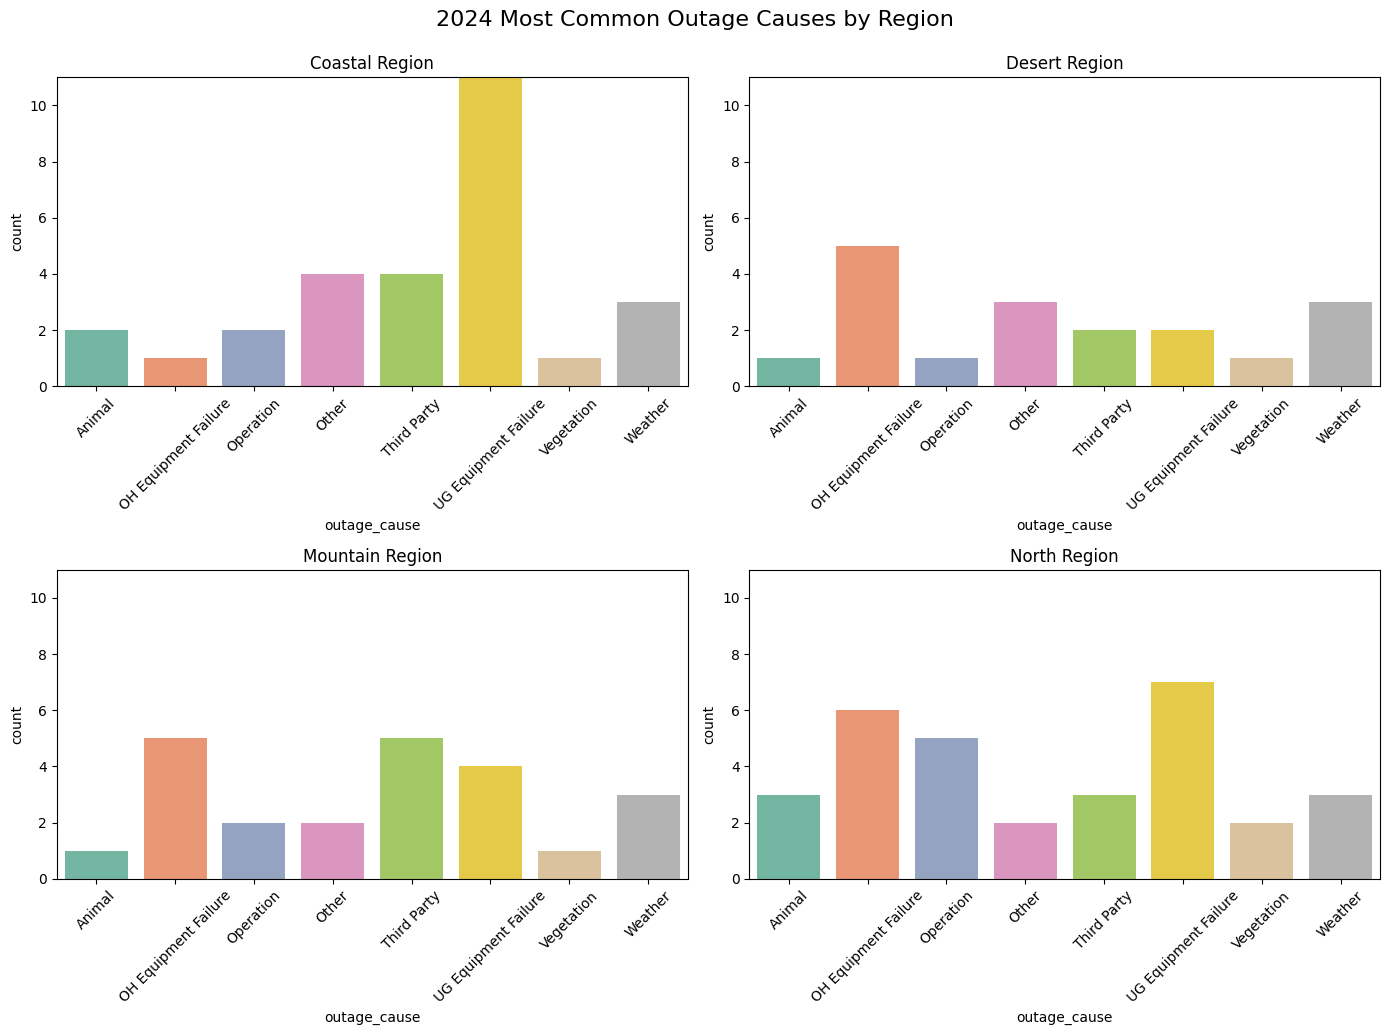

In [15]:
# histograms for most common outages per region

max_count = outage_per_region['count'].max()

coastal = outage_per_region[outage_per_region["region"] == "Coastal"]
desert = outage_per_region[outage_per_region["region"] == "Desert"]
mountain = outage_per_region[outage_per_region["region"] == "Mountain"]
north = outage_per_region[outage_per_region["region"] == "North"]

all_causes = sorted(outage_cause['outage_cause'])
def fill_missing_causes(df):
    return (
        df.set_index('outage_cause')
        .reindex(all_causes, fill_value=0)
        .reset_index()
    )
coastal = fill_missing_causes(coastal)
desert = fill_missing_causes(desert)
mountain = fill_missing_causes(mountain)
north = fill_missing_causes(north)



palette = sns.color_palette("Set2")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))



sns.barplot(data=coastal, x="outage_cause", y="count",hue="outage_cause", ax=axs[0, 0], palette=palette)
axs[0, 0].set_title("Coastal Region")
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].set_ylim(0, max_count)

sns.barplot(data=desert, x="outage_cause", y="count",hue="outage_cause", ax=axs[0, 1], palette=palette)
axs[0, 1].set_title("Desert Region")
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].set_ylim(0, max_count)

sns.barplot(data=mountain, x="outage_cause", y="count",hue="outage_cause", ax=axs[1, 0], palette=palette)
axs[1, 0].set_title("Mountain Region")
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].set_ylim(0, max_count)

sns.barplot(data=north, x="outage_cause", y="count",hue="outage_cause", ax=axs[1, 1], palette=palette)
axs[1, 1].set_title("North Region")
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].set_ylim(0, max_count)

plt.tight_layout()
plt.suptitle("2024 Most Common Outage Causes by Region", fontsize=16, y=1.03)  
plt.show()


In [16]:
# Circuit Type Count Per region 
circuit_per_region = (
    df
    .groupby(['region', 'circuit_name', 'voltage','customer_count', 'circuit_miles', 'percent_overhead', 'percent_underground'])
    .size()
    .reset_index(name = 'outage_count')
    .sort_values(by = ['region', 'outage_count'], ascending = False)
    .reset_index(drop=True)
)

circuit_per_region

,region,circuit_name,voltage,customer_count,circuit_miles,percent_overhead,percent_underground,outage_count
0,North,Logan,16,3220,45,60,40,10
1,North,Hoover,12,2610,112,66,34,7
2,North,Yellow,4,1706,43,85,15,7
3,North,Alabama,12,3447,29,82,18,4
4,North,Washington,12,1312,38,18,82,3
5,Mountain,Magenta,16,2367,129,75,25,10
6,Mountain,Lincoln,16,1634,95,65,35,6
7,Mountain,Johnson,16,1641,64,60,40,3
8,Mountain,Thunder,16,3945,72,85,15,2
9,Mountain,Grand,4,500,11,90,10,1


In [17]:
# Total Customer Minutes Interrupted Per Region

total_cmi_per_region = (
    total_cmi
    .groupby('region')['total_cmi']
    .sum()
    .reset_index(name='total_cmi')
    .sort_values(by = 'total_cmi', ascending=False)
    .reset_index(drop=True)
    
)

total_cmi_per_region

,region,total_cmi
0,North,25597270
1,Coastal,21451249
2,Mountain,21224894
3,Desert,7696578


In [18]:
outages_per_region_2024 = (
    df
    .groupby('region')
    .size()
    .reset_index(name='outage_count_2024')
    .sort_values(by='outage_count_2024', ascending=False)
    .reset_index(drop=True)
)

circuits_per_region = (
    df[['region', 'circuit_name']]
    .drop_duplicates()
    .groupby('region')
    .size()
    .reset_index(name='circuit_count')
)

# Merge to include per-circuit average
outages_per_region_2024 = outages_per_region_2024.merge(
    circuits_per_region, on='region', how='left'
)

outages_per_region_2024['outages_per_circuit'] = (
    outages_per_region_2024['outage_count_2024'] / outages_per_region_2024['circuit_count']
)

outages_per_region_2024

,region,outage_count_2024,circuit_count,outages_per_circuit
0,North,31,5,6.200000
1,Coastal,28,5,5.600000
2,Mountain,23,6,3.833333
3,Desert,18,5,3.600000


/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/1446971635.py:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(
/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/1446971635.py:19: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


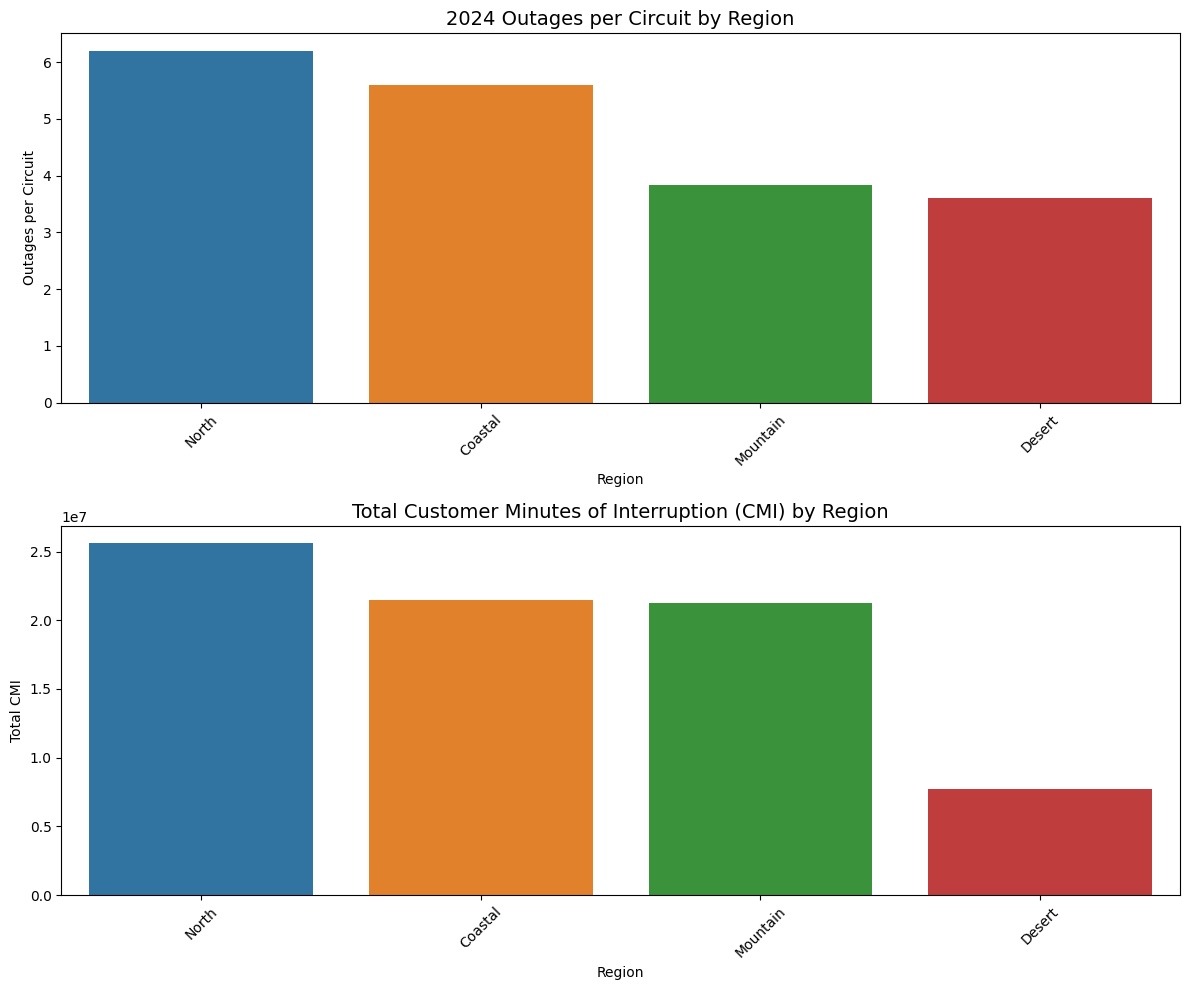

In [19]:

palette = sns.color_palette(palette = 'tab10')
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Circuit outages per Region
sns.barplot(
    data=outages_per_region_2024,
    x='region',
    y='outages_per_circuit',
    hue='region',
    ax = axs[0],
    palette=palette  
)
axs[0].set_title('2024 Outages per Circuit by Region', fontsize=14)
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Outages per Circuit')
axs[0].tick_params(axis = 'x', rotation = 45)

# Total Cmi Per Region
sns.barplot(
    data = total_cmi_per_region,
    x = 'region',
    y = 'total_cmi',
    hue = 'region',
    ax=axs[1],
    palette = palette
)

axs[1].set_title('Total Customer Minutes of Interruption (CMI) by Region', fontsize=14)
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Total CMI')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analysis per Outage Cause 
* Cause of Most Outages 
* Average, Median, and Total Duration Per Outage by Outage Cause 
* Average, Median, and Total CMI Per Outage by Outage Cause 

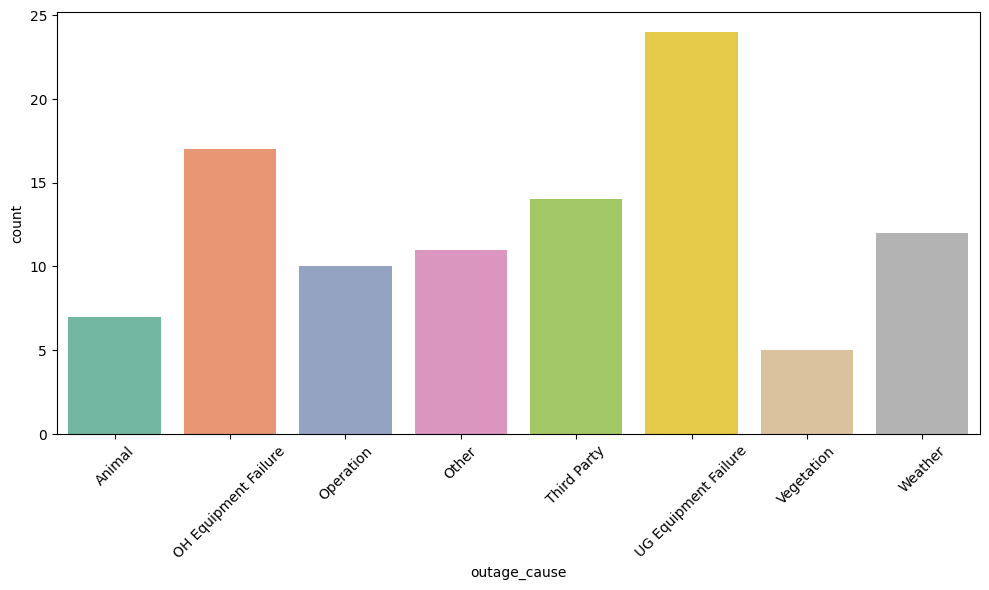

In [20]:
# top outage causes 

top_outage_causes_2024 = (
    df
    .groupby("outage_cause")
    .size()
    .reset_index(name="count")
    .sort_values(by='outage_cause', ascending = True)
    .reset_index(drop=True)
)

# top_outage_causes_2024

plt.figure(figsize=(10,6))

sns.barplot(top_outage_causes_2024, x = 'outage_cause', y = 'count', hue = 'outage_cause', palette = 'Set2', legend=False)
plt.tick_params(rotation = 45, axis = 'x')
plt.tight_layout()

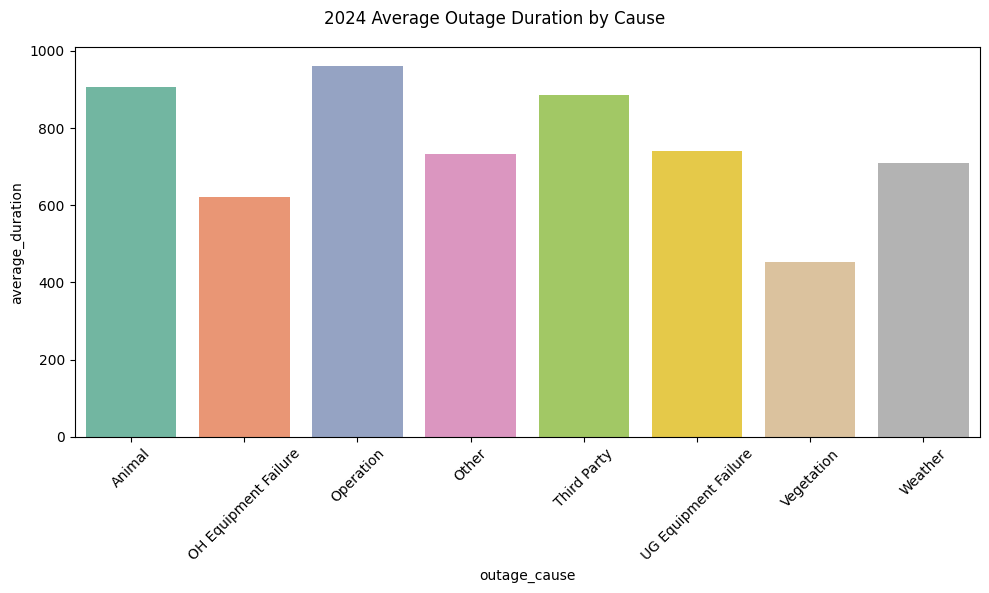

In [21]:
#  Outage Cause Average Duration Per Outage - 2024
outage_cause_avg_duration = (
    df
    .groupby('outage_cause')['outage_duration']
    .mean()
    .reset_index(name='average_duration')
    .sort_values(by='outage_cause', ascending = True)
    .reset_index(drop=True)
)
plt.figure(figsize = (10,6))
sns.barplot(
    data = outage_cause_avg_duration,
    x = 'outage_cause',
    y='average_duration',
    hue = 'outage_cause',
    palette = 'Set2'
)
plt.tick_params(axis = 'x', rotation = 45)
plt.suptitle('2024 Average Outage Duration by Cause')
plt.tight_layout()

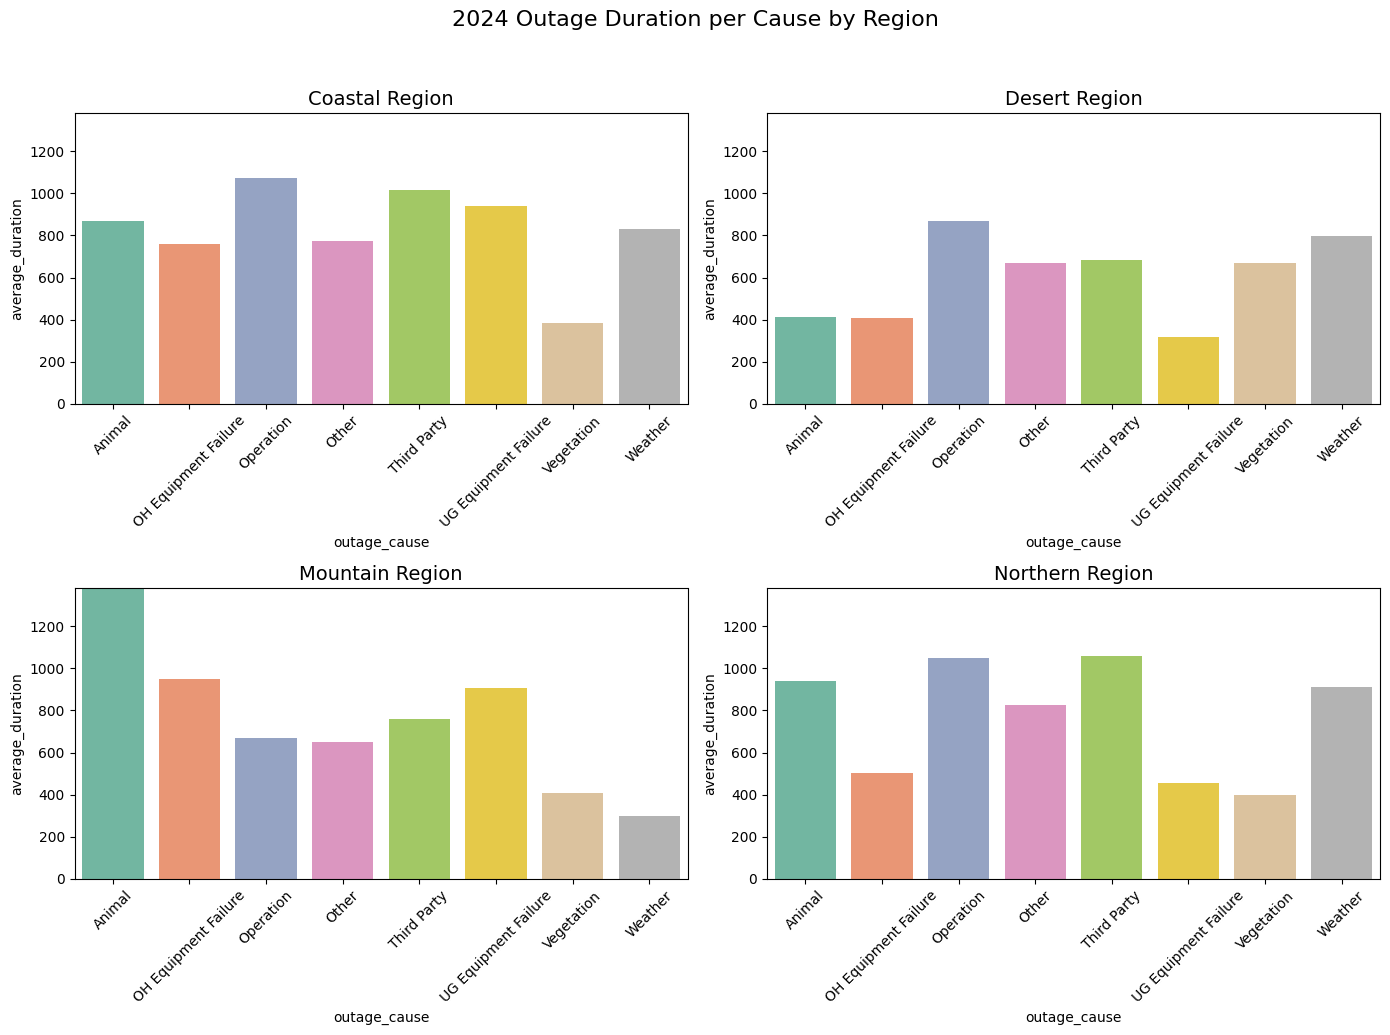

In [22]:
# Average Duration of Outage per outage cause per region 
outage_cause_duration_by_region = (
    df
    .groupby(['region','outage_cause'])['outage_duration']
    .mean()
    .reset_index(name='average_duration')
    .sort_values(by=['region','average_duration'], ascending = False)
    .reset_index(drop=True)
)
outage_cause_duration_by_region

palette = sns.color_palette("Set2")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

coastal = outage_cause_duration_by_region[outage_cause_duration_by_region["region"] == "Coastal"]
desert = outage_cause_duration_by_region[outage_cause_duration_by_region["region"] == "Desert"]
mountain = outage_cause_duration_by_region[outage_cause_duration_by_region["region"] == "Mountain"]
north = outage_cause_duration_by_region[outage_cause_duration_by_region["region"] == "North"]

max_count = outage_cause_duration_by_region['average_duration'].max()
all_causes = sorted(outage_cause['outage_cause'])
def fill_missing_causes(df):
    return (
        df.set_index('outage_cause')
        .reindex(all_causes, fill_value=0)
        .reset_index()
    )
coastal = fill_missing_causes(coastal)
desert = fill_missing_causes(desert)
mountain = fill_missing_causes(mountain)
north = fill_missing_causes(north)

sns.barplot(
    coastal,
    x = 'outage_cause',
    y = 'average_duration',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[0,0]
)
axs[0][0].set_title('Coastal Region', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')
axs[0][0].set_ylim(0,max_count)

sns.barplot(
    desert,
    x = 'outage_cause',
    y = 'average_duration',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[0,1]
)
axs[0][1].set_title('Desert Region', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')
axs[0][1].set_ylim(0,max_count)

sns.barplot(
    mountain,
    x = 'outage_cause',
    y = 'average_duration',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[1,0]
)
axs[1][0].set_title('Mountain Region', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')
axs[1][0].set_ylim(0,max_count)

sns.barplot(
    north,
    x = 'outage_cause',
    y = 'average_duration',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[1,1]
)
axs[1][1].set_title('Northern Region', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')
axs[1][1].set_ylim(0,max_count)

plt.suptitle("2024 Outage Duration per Cause by Region", fontsize=16, y=1.03) 
plt.tight_layout()

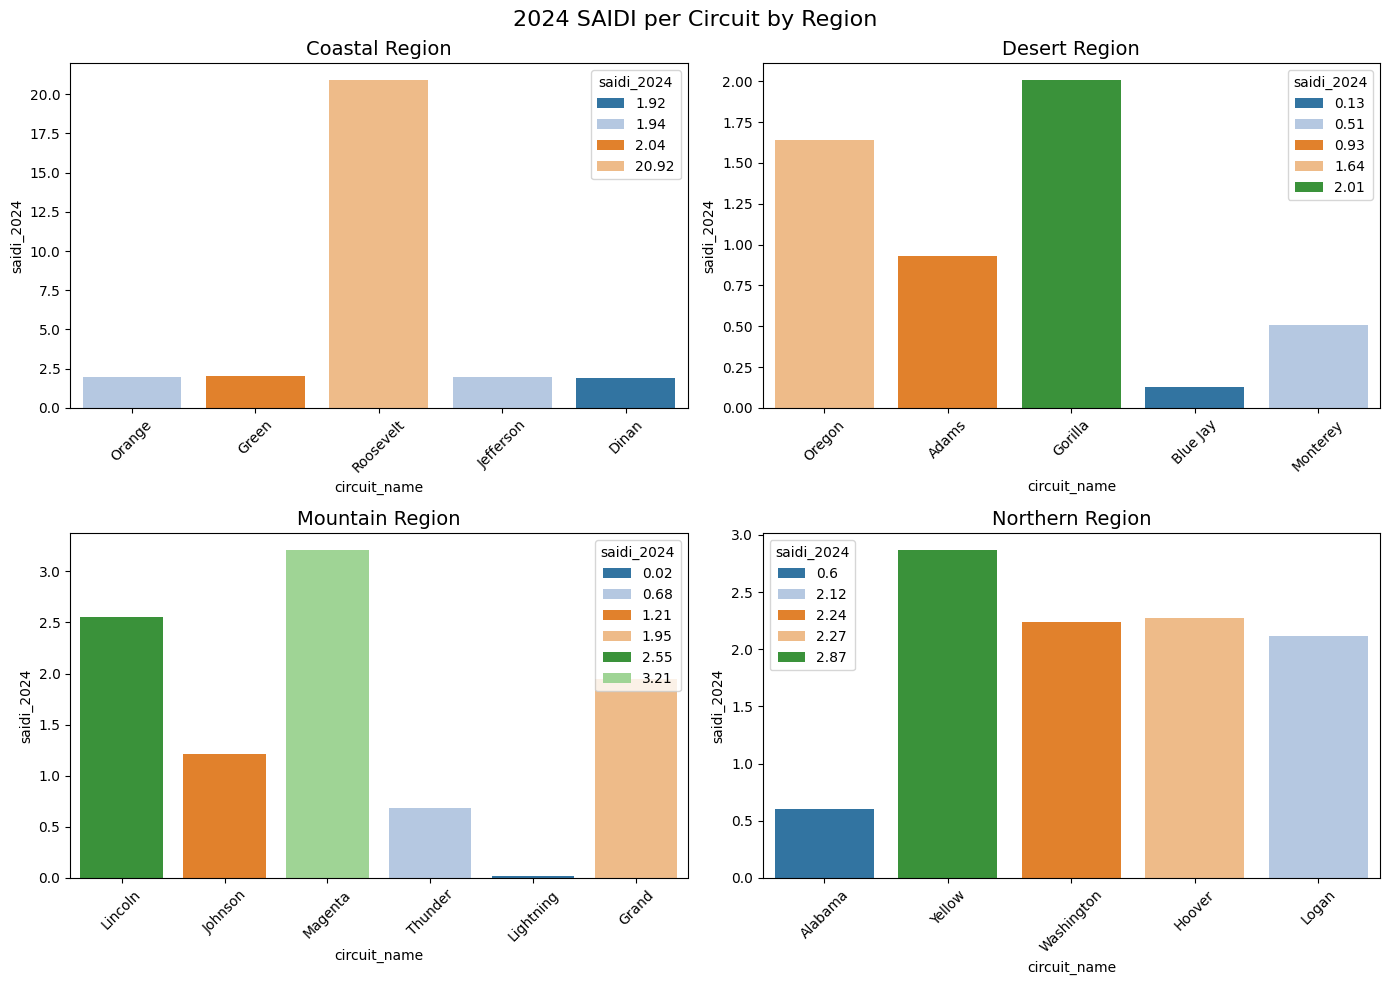

In [81]:
# saidi  per region 

coastal = circuit[ circuit['region'] == 'Coastal' ]
desert = circuit[ circuit['region'] == 'Desert' ]
mountain = circuit[ circuit['region'] == 'Mountain' ]
north = circuit[ circuit['region'] == 'North' ]

palette = 'tab20'
fig, axs = plt.subplots(2,2, figsize = (14,10) )

sns.barplot(coastal, x = coastal['circuit_name'], y=coastal['saidi_2024'], hue = coastal['saidi_2024'], palette = palette, ax = axs[0][0])
axs[0][0].set_title('Coastal Region', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')

sns.barplot(desert, x = desert['circuit_name'], y=desert['saidi_2024'], hue = desert['saidi_2024'], palette = palette, ax = axs[0][1])
axs[0][1].set_title('Desert Region', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')

sns.barplot(mountain, x = mountain['circuit_name'], y=mountain['saidi_2024'], hue = mountain['saidi_2024'], palette = palette, ax = axs[1][0])
axs[1][0].set_title('Mountain Region', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')

sns.barplot(north, x = north['circuit_name'], y=north['saidi_2024'], hue = north['saidi_2024'], palette = palette, ax = axs[1][1])
axs[1][1].set_title('Northern Region', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')

plt.suptitle('2024 SAIDI per Circuit by Region', fontsize=16)
plt.tight_layout()

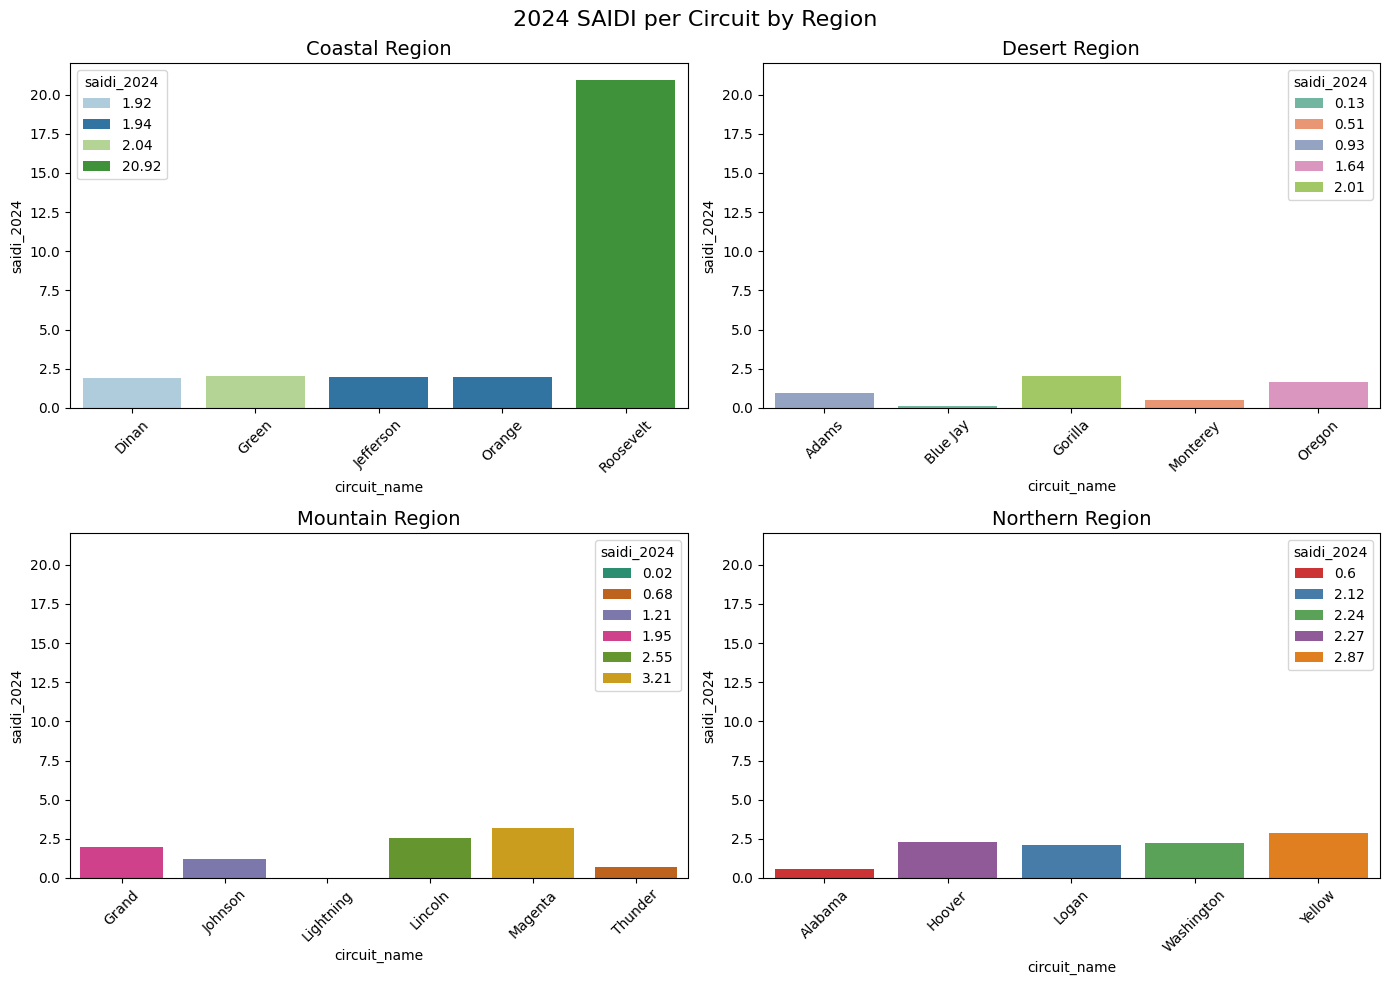

In [120]:
# saidi per region
circuit_copy = circuit.copy().sort_values(by = 'circuit_name')

coastal = circuit_copy[ circuit_copy['region'] == 'Coastal' ]
desert = circuit_copy[ circuit_copy['region'] == 'Desert' ]
mountain = circuit_copy[ circuit_copy['region'] == 'Mountain' ]
north = circuit_copy[ circuit_copy['region'] == 'North' ]


palette = 'tab10'
fig, axs = plt.subplots(2,2, figsize = (14,10) )

sns.barplot(coastal, x = coastal['circuit_name'], y=coastal['saidi_2024'], hue = coastal['saidi_2024'], palette = 'Paired', ax = axs[0][0], )
axs[0][0].set_title('Coastal Region', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')
axs[0][0].set_ylim(0,22)

sns.barplot(desert, x = desert['circuit_name'], y=desert['saidi_2024'], hue = desert['saidi_2024'], palette = 'Set2', ax = axs[0][1])
axs[0][1].set_title('Desert Region', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')
axs[0][1].set_ylim(0,22)

sns.barplot(mountain, x = mountain['circuit_name'], y=mountain['saidi_2024'], hue = mountain['saidi_2024'], palette = 'Dark2', ax = axs[1][0])
axs[1][0].set_title('Mountain Region', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')
axs[1][0].set_ylim(0,22)

sns.barplot(north, x = north['circuit_name'], y=north['saidi_2024'], hue = north['saidi_2024'], palette = 'Set1', ax = axs[1][1])
axs[1][1].set_title('Northern Region', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')
axs[1][1].set_ylim(0,22)

plt.suptitle('2024 SAIDI per Circuit by Region', fontsize=16)
plt.tight_layout()

/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/448575311.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['saidi_proportion'] = region_df['saidi_2024'] / max_val
/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/448575311.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['saidi_proportion'] = region_df['saidi_2024'] / max_val
/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/448575311.py:11: SettingWithCopyWarning: 
A value is trying

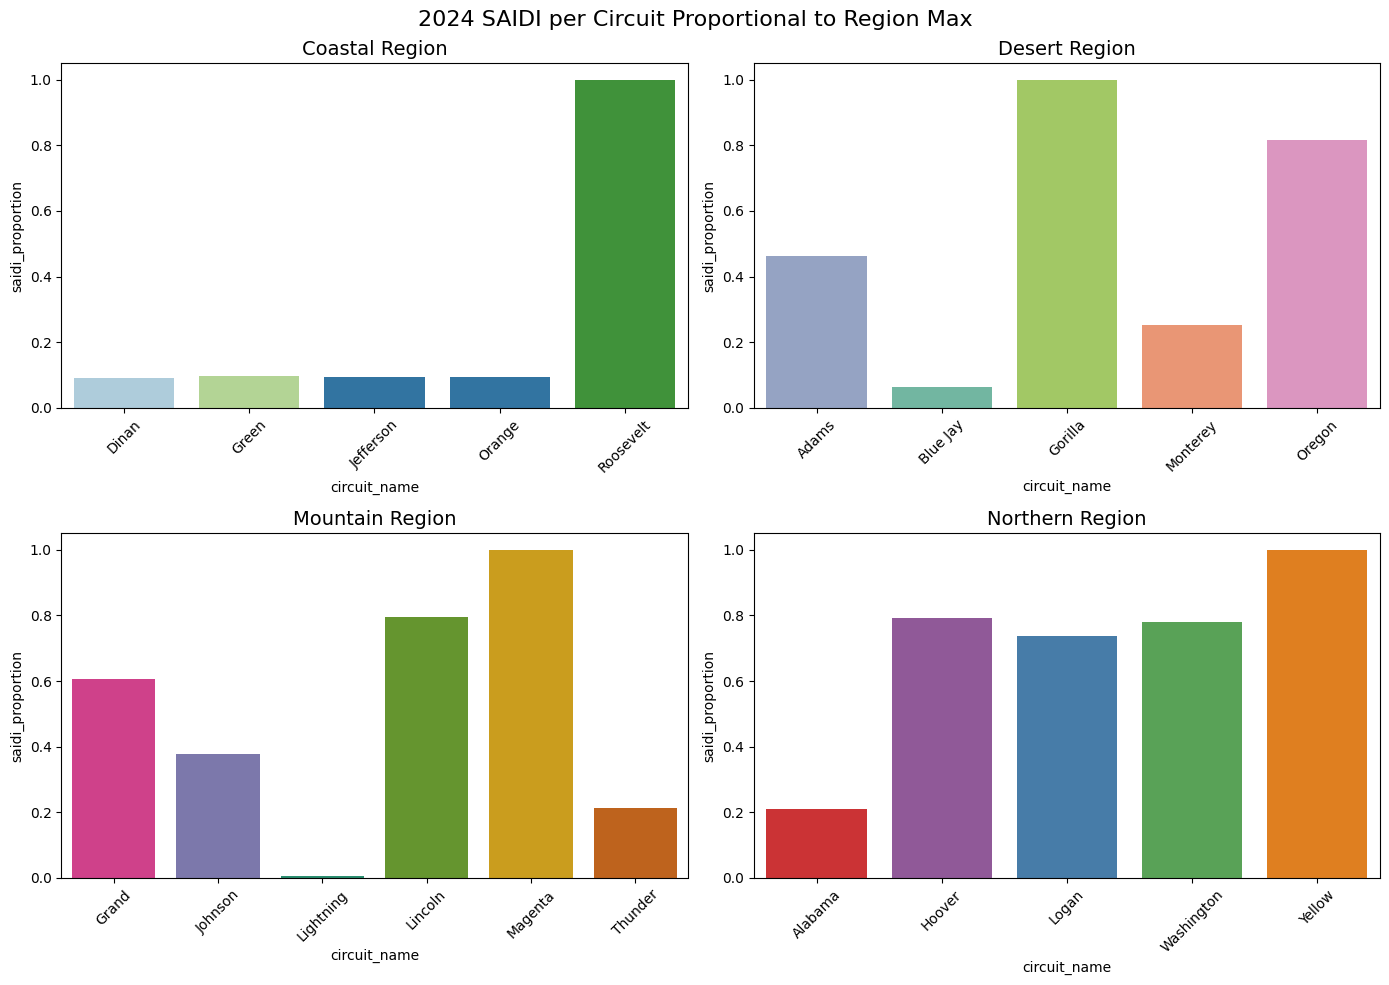

In [122]:
circuit_copy = circuit.copy().sort_values(by = 'circuit_name')

coastal = circuit_copy[ circuit_copy['region'] == 'Coastal' ]
desert = circuit_copy[ circuit_copy['region'] == 'Desert' ]
mountain = circuit_copy[ circuit_copy['region'] == 'Mountain' ]
north = circuit_copy[ circuit_copy['region'] == 'North' ]

# Per-region normalization by max
for region_df in [coastal, desert, mountain, north]:
    max_val = region_df['saidi_2024'].max()
    region_df['saidi_proportion'] = region_df['saidi_2024'] / max_val


# coastal['saidi_2024'].max()
fig, axs = plt.subplots(2,2,figsize = (14,10))

sns.barplot(coastal, x = 'circuit_name', y='saidi_proportion', hue = coastal['saidi_2024'], palette = 'Paired', ax = axs[0][0], legend = False)
axs[0][0].set_title('Coastal Region', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')
# axs[0][0].set_ylim(0,max_saidi)

sns.barplot(desert, x = 'circuit_name', y='saidi_proportion', hue = desert['saidi_2024'], palette = 'Set2', ax = axs[0][1],legend = False)
axs[0][1].set_title('Desert Region', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')
# axs[0][1].set_ylim(0,max_saidi)

sns.barplot(mountain, x = 'circuit_name', y='saidi_proportion', hue = mountain['saidi_2024'], palette = 'Dark2', ax = axs[1][0],legend = False)
axs[1][0].set_title('Mountain Region', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')
# axs[1][0].set_ylim(0,max_saidi)

sns.barplot(north, x = 'circuit_name', y='saidi_proportion', hue = north['saidi_2024'], palette = 'Set1', ax = axs[1][1],legend = False)
axs[1][1].set_title('Northern Region', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')
# axs[1][1].set_ylim(0,max_saidi)

plt.suptitle('2024 SAIDI per Circuit Proportional to Region Max', fontsize=16)
plt.tight_layout()

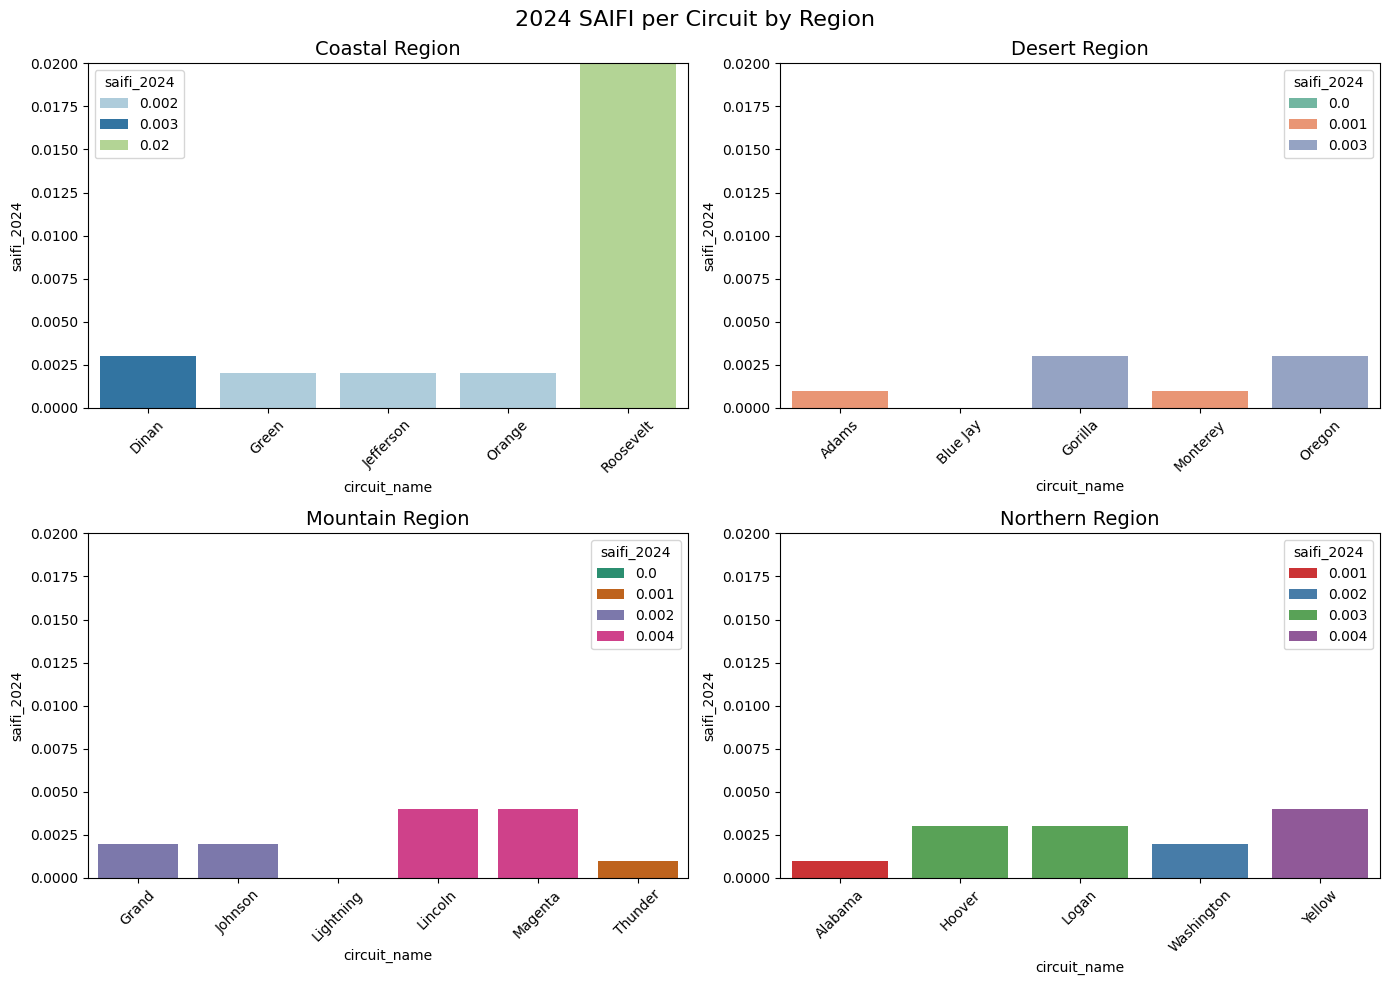

In [125]:
# saidi per region
circuit_copy = circuit.copy().sort_values(by = 'circuit_name')

coastal = circuit_copy[ circuit_copy['region'] == 'Coastal' ]
desert = circuit_copy[ circuit_copy['region'] == 'Desert' ]
mountain = circuit_copy[ circuit_copy['region'] == 'Mountain' ]
north = circuit_copy[ circuit_copy['region'] == 'North' ]


max_saifi = circuit_copy['saifi_2024'].max()

fig, axs = plt.subplots(2,2, figsize = (14,10) )

sns.barplot(coastal, x = coastal['circuit_name'], y=coastal['saifi_2024'], hue = coastal['saifi_2024'], palette = 'Paired', ax = axs[0][0], )
axs[0][0].set_title('Coastal Region', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')
axs[0][0].set_ylim(0,max_saifi)

sns.barplot(desert, x = desert['circuit_name'], y=desert['saifi_2024'], hue = desert['saifi_2024'], palette = 'Set2', ax = axs[0][1])
axs[0][1].set_title('Desert Region', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')
axs[0][1].set_ylim(0,max_saifi)

sns.barplot(mountain, x = mountain['circuit_name'], y=mountain['saifi_2024'], hue = mountain['saifi_2024'], palette = 'Dark2', ax = axs[1][0])
axs[1][0].set_title('Mountain Region', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')
axs[1][0].set_ylim(0,max_saifi)

sns.barplot(north, x = north['circuit_name'], y=north['saifi_2024'], hue = north['saifi_2024'], palette = 'Set1', ax = axs[1][1])
axs[1][1].set_title('Northern Region', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')
axs[1][1].set_ylim(0,max_saifi)

plt.suptitle('2024 SAIFI per Circuit by Region', fontsize=16)
plt.tight_layout()

/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/1795712776.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['saifi_proportion'] = region_df['saifi_2024'] / max_val
/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/1795712776.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['saifi_proportion'] = region_df['saifi_2024'] / max_val
/var/folders/b2/dv4s0x994dz37s4d7fv56q8r0000gn/T/ipykernel_29674/1795712776.py:12: SettingWithCopyWarning: 
A value is try

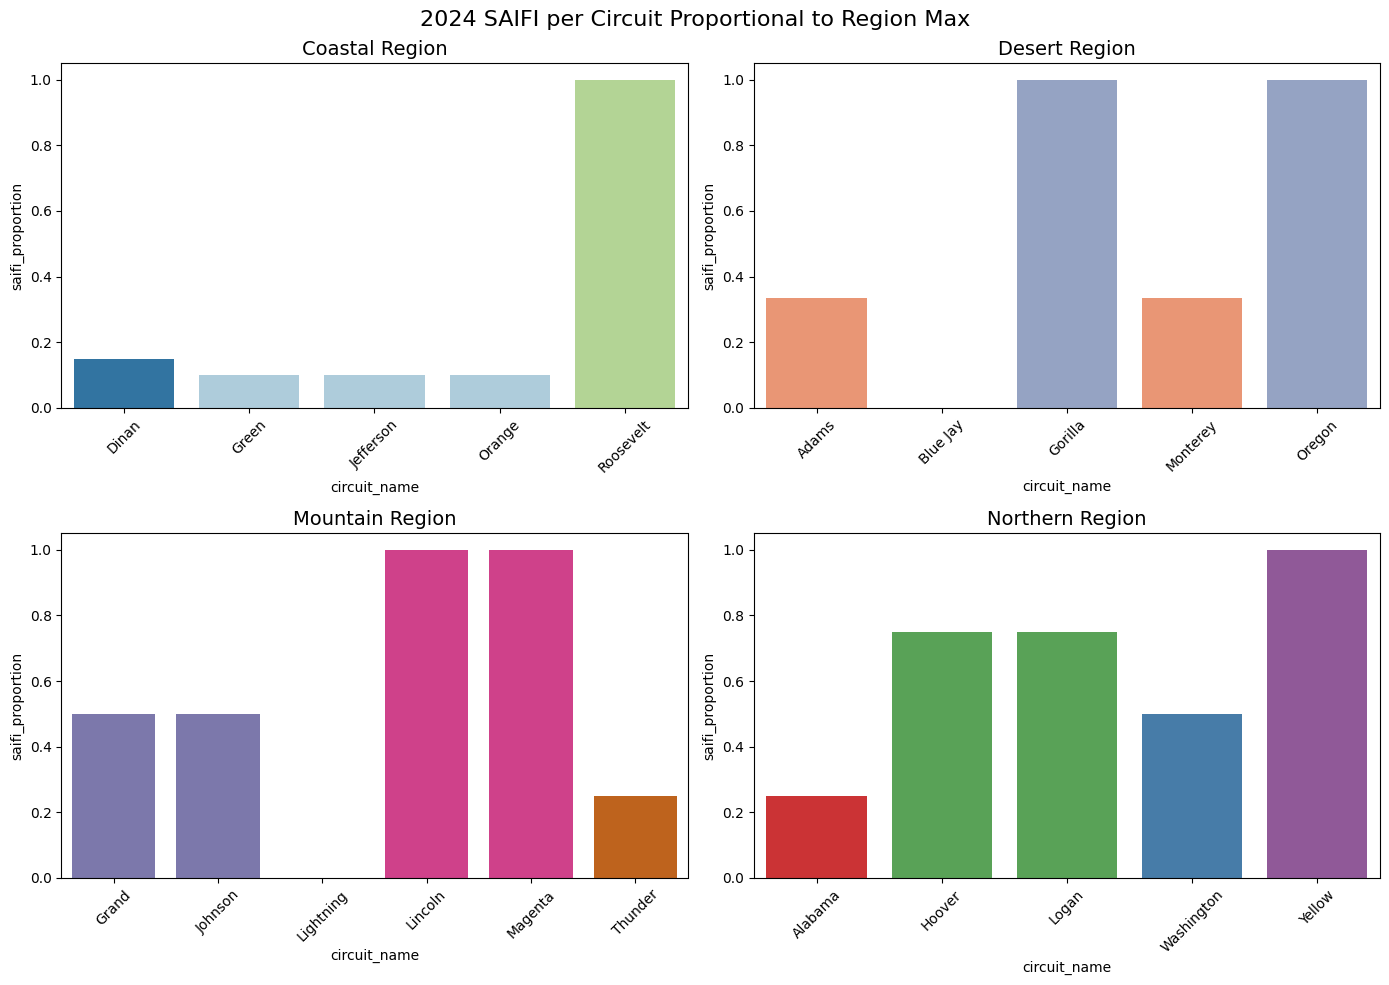

In [123]:
# normalized saifi 
circuit_copy = circuit.copy().sort_values(by = 'circuit_name')

coastal = circuit_copy[ circuit_copy['region'] == 'Coastal' ]
desert = circuit_copy[ circuit_copy['region'] == 'Desert' ]
mountain = circuit_copy[ circuit_copy['region'] == 'Mountain' ]
north = circuit_copy[ circuit_copy['region'] == 'North' ]

# Per-region normalization by max
for region_df in [coastal, desert, mountain, north]:
    max_val = region_df['saifi_2024'].max()
    region_df['saifi_proportion'] = region_df['saifi_2024'] / max_val



fig, axs = plt.subplots(2,2,figsize = (14,10))

sns.barplot(coastal, x = 'circuit_name', y='saifi_proportion', hue = coastal['saifi_2024'], palette = 'Paired', ax = axs[0][0], legend = False)
axs[0][0].set_title('Coastal Region', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')
# axs[0][0].set_ylim(0,max_saidi)

sns.barplot(desert, x = 'circuit_name', y='saifi_proportion', hue = desert['saifi_2024'], palette = 'Set2', ax = axs[0][1],legend = False)
axs[0][1].set_title('Desert Region', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')
# axs[0][1].set_ylim(0,max_saidi)

sns.barplot(mountain, x = 'circuit_name', y='saifi_proportion', hue = mountain['saifi_2024'], palette = 'Dark2', ax = axs[1][0],legend = False)
axs[1][0].set_title('Mountain Region', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')
# axs[1][0].set_ylim(0,max_saidi)

sns.barplot(north, x = 'circuit_name', y='saifi_proportion', hue = north['saifi_2024'], palette = 'Set1', ax = axs[1][1],legend = False)
axs[1][1].set_title('Northern Region', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')
# axs[1][1].set_ylim(0,max_saidi)

plt.suptitle('2024 SAIFI per Circuit Proportional to Region Max', fontsize=16)
plt.tight_layout()

In [65]:
#  Outage Cause Median Duration Per Outage - 2024
outage_cause_median_duration = (
    df
    .groupby('outage_cause')['outage_duration']
    .median()
    .reset_index(name='median_duration')
    .sort_values(by='median_duration', ascending = False)
    .reset_index(drop=True)
)
outage_cause_median_duration

,outage_cause,median_duration
0,Operation,935.5
1,Third Party,926.5
2,Animal,868.0
3,Other,837.0
4,Weather,760.0
5,UG Equipment Failure,651.5
6,OH Equipment Failure,555.0
7,Vegetation,410.0


In [66]:
#  Average CMI per outage per outage cause 

outage_cause_avg_cmi = (
    df
    .groupby('outage_cause')['cmi']
    .mean()
    .reset_index(name='average_cmi_per_outage')
    .sort_values(by='average_cmi_per_outage', ascending = False)
    .reset_index(drop=True)
)

outage_cause_avg_cmi['average_cmi_per_outage'] = (
    outage_cause_avg_cmi['average_cmi_per_outage'].round(2)
)
outage_cause_avg_cmi



,outage_cause,average_cmi_per_outage
0,Animal,1104097.57
1,Third Party,1011896.50
2,Other,819142.27
3,UG Equipment Failure,782651.08
4,Operation,713754.40
5,OH Equipment Failure,671559.12
6,Weather,458098.42
7,Vegetation,445867.20


In [25]:
# Median CMI per outage cause per outage 
outage_cause_median_cmi = (
    df
    .groupby('outage_cause')['cmi']
    .median()
    .reset_index(name='median_cmi_per_outage')
    .sort_values(by='median_cmi_per_outage', ascending = False)
    .reset_index(drop=True)
)

outage_cause_median_cmi['median_cmi_per_outage'] = (
    outage_cause_median_cmi['median_cmi_per_outage'].round(2)
)
outage_cause_median_cmi

,outage_cause,median_cmi_per_outage
0,Third Party,840316.5
1,Animal,806382.0
2,Vegetation,512820.0
3,Operation,488365.0
4,Other,472524.0
5,UG Equipment Failure,401674.0
6,Weather,357557.5
7,OH Equipment Failure,350020.0


In [26]:
# Total CMI per outage cause 
outage_cause_total_cmi = (
    df
    .groupby('outage_cause')['cmi']
    .median()
    .reset_index(name='total_cmi')
    .sort_values(by='total_cmi', ascending = False)
    .reset_index(drop=True)
)

outage_cause_total_cmi['total_cmi'] = (
    outage_cause_total_cmi['total_cmi'].round(2)
)
outage_cause_total_cmi

,outage_cause,total_cmi
0,Third Party,840316.5
1,Animal,806382.0
2,Vegetation,512820.0
3,Operation,488365.0
4,Other,472524.0
5,UG Equipment Failure,401674.0
6,Weather,357557.5
7,OH Equipment Failure,350020.0


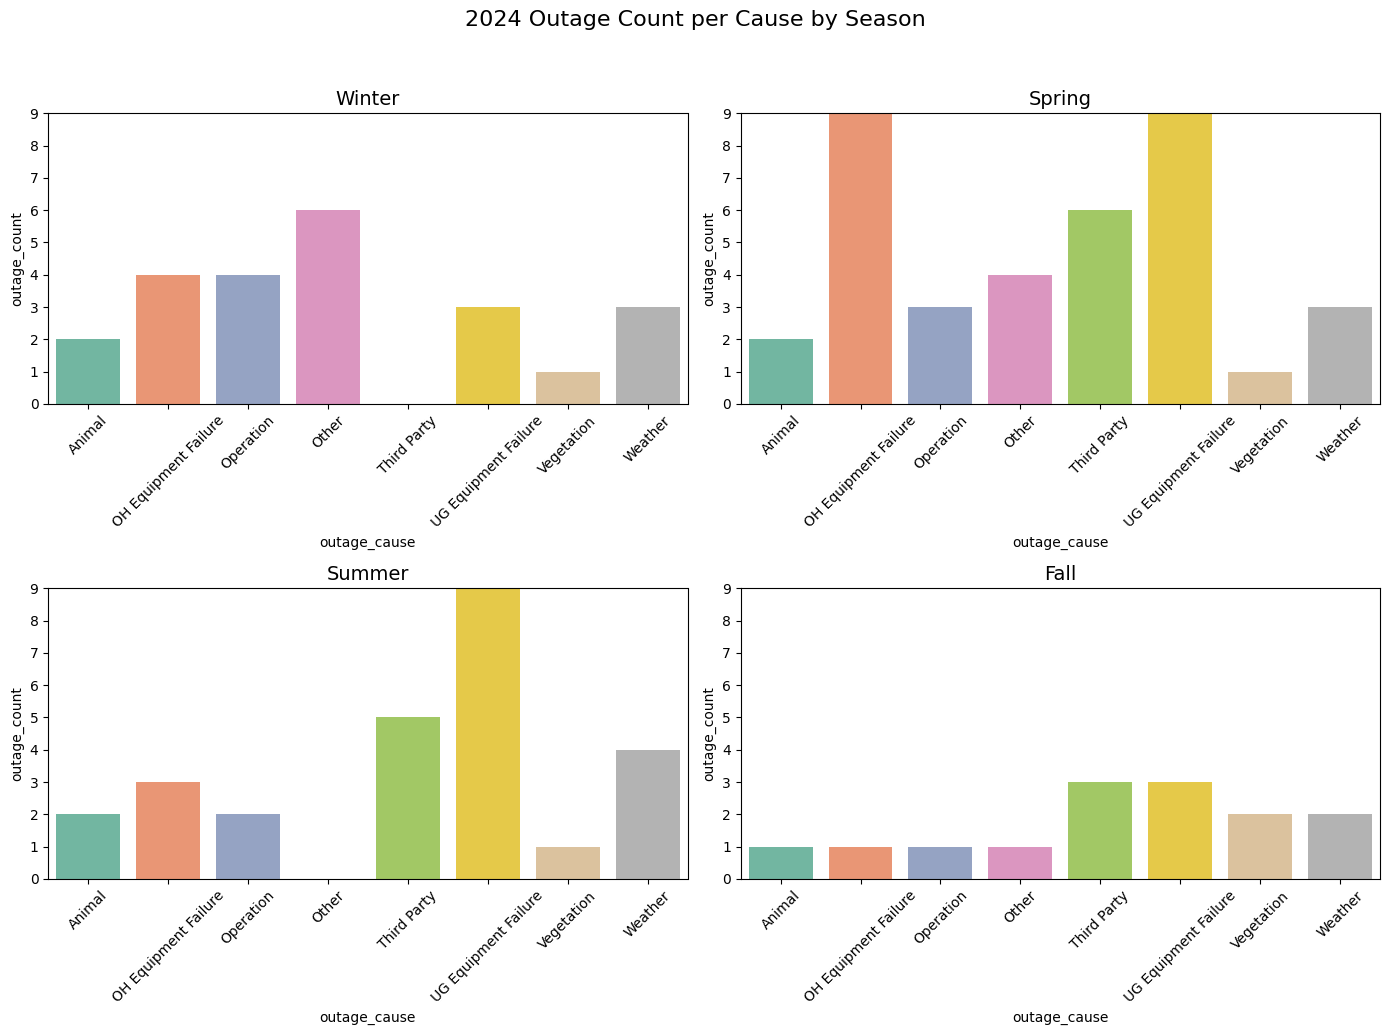

In [82]:
# Outage Cause Per Season
outage_cause_per_season = (
    df
    .groupby(['season', 'outage_cause'])
    .size()
    .reset_index(name='outage_count')
    # .sort_values(by=['season', 'outage_count'], ascending = False)
    # .reset_index(drop=True)
)

max_count = outage_cause_per_season["outage_count"].max()

# Then in each subplot, add:




palette = sns.color_palette("Set2")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

winter = outage_cause_per_season[outage_cause_per_season["season"] == "Winter"]
spring =  outage_cause_per_season[outage_cause_per_season["season"] == "Spring"]
summer =  outage_cause_per_season[outage_cause_per_season["season"] == "Summer"]
fall =  outage_cause_per_season[outage_cause_per_season["season"] == "Fall"]

all_causes = sorted(outage_cause['outage_cause'])
def fill_missing_causes(df_season):
    return (
        df_season.set_index('outage_cause')
        .reindex(all_causes, fill_value=0)
        .reset_index()
    )
winter = fill_missing_causes(winter)
spring = fill_missing_causes(spring)
summer = fill_missing_causes(summer)
fall   = fill_missing_causes(fall)



sns.barplot(
    winter,
    x = 'outage_cause',
    y = 'outage_count',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[0,0]
)
axs[0][0].set_title('Winter', fontsize=14)
axs[0][0].tick_params(rotation = 45, axis = 'x')
axs[0, 0].set_ylim(0, max_count)

sns.barplot(
    spring,
    x = 'outage_cause',
    y = 'outage_count',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[0,1]
)
axs[0][1].set_title('Spring', fontsize=14)
axs[0][1].tick_params(rotation = 45, axis = 'x')
axs[0, 1].set_ylim(0, max_count)

sns.barplot(
    summer,
    x = 'outage_cause',
    y = 'outage_count',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[1,0]
)
axs[1][0].set_title('Summer', fontsize=14)
axs[1][0].tick_params(rotation = 45, axis = 'x')
axs[1, 0].set_ylim(0, max_count)

sns.barplot(
    fall,
    x = 'outage_cause',
    y = 'outage_count',
    hue = 'outage_cause',
    palette = palette,
    ax=axs[1,1]
)
axs[1][1].set_title('Fall', fontsize=14)
axs[1][1].tick_params(rotation = 45, axis = 'x')
axs[1, 1].set_ylim(0, max_count)

plt.suptitle("2024 Outage Count per Cause by Season", fontsize=16, y=1.03) 
plt.tight_layout()

In [28]:
# Outage Cause Per Season by region
outage_cause_per_season_by_region = (
    df
    .groupby(['region', 'season', 'outage_cause'])
    .size()
    .reset_index(name='outage_count')
)

top_outage_cause_per_season = (
    outage_cause_per_season_by_region
    .sort_values(['region', 'season', 'outage_count'], ascending=[True, True, False])
    .groupby(['region', 'season'], as_index=False)
    .first()
)

top_outage_cause_per_season

,region,season,outage_cause,outage_count
0,Coastal,Fall,Third Party,2
1,Coastal,Spring,UG Equipment Failure,4
2,Coastal,Summer,UG Equipment Failure,3
3,Coastal,Winter,Other,3
4,Desert,Fall,OH Equipment Failure,1
5,Desert,Spring,OH Equipment Failure,3
6,Desert,Summer,UG Equipment Failure,2
7,Desert,Winter,Other,2
8,Mountain,Fall,Third Party,1
9,Mountain,Spring,OH Equipment Failure,4


In [30]:
# df.to_excel("/Users/gerardogutierrez/Desktop/ITC_2025/ibec_enriched.xlsx", index = False)